<a href="https://colab.research.google.com/github/pseudope/Parrot_5th_Level1/blob/main/6%3A37_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python3
!pip install einops
#!pip install tensorflow --user

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, BatchNormalization

from einops import rearrange
from sklearn.model_selection import train_test_split

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

11501568/11490434 [==============================] - 0s 0us/step
X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)


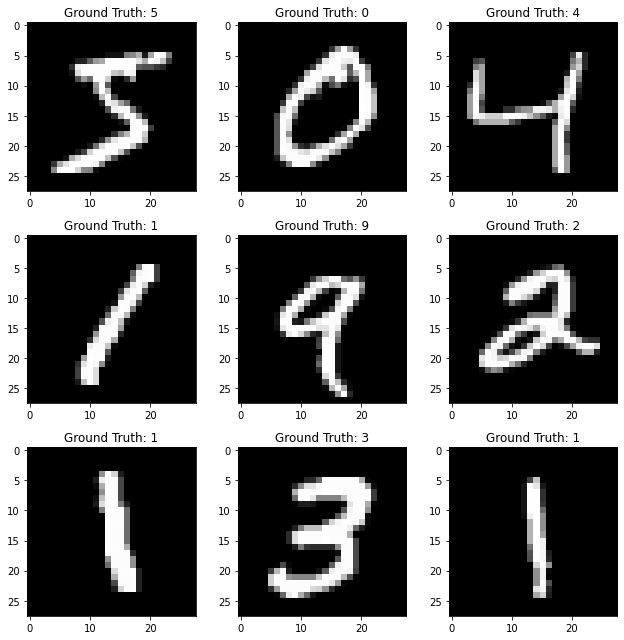

In [3]:
fig = plt.figure(figsize=(9, 9))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(X_train[i], cmap="gray", interpolation="none")
    target = y_train[i]
    plt.title("Ground Truth: {}".format(int(target)))

plt.show()

In [4]:
target_size = 10   # 0 ~ 9, 총 9개

### 주의: 흑백 데이터여도 channel 차원을 살려주어야 정상적으로 작동합니다
X_train = rearrange(X_train, "b h w -> b h w 1")
X_test = rearrange(X_test, "b h w -> b h w 1")

X_train = X_train.astype("float32") / (2 ** 8 - 1)   # 255로 scaling
X_test = X_test.astype("float32") / (2 ** 8 - 1)     # 255로 scaling

y_train = to_categorical(y_train, target_size)       # 타겟을 정수로 변환
y_test = to_categorical(y_test, target_size)         # 타겟을 정수로 변환

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)
(48000, 10)
(12000, 10)
(10000, 10)


In [16]:
inputs = Input(shape=(28, 28, 1))

X = Conv2D(filters=512, kernel_size=(3, 3), padding="Same")(inputs)
X = BatchNormalization()(X)
X = Activation("relu")(X)
X = Conv2D(filters=256, kernel_size=(3, 3), padding="Same", activation="relu")(X)
#X = Dropout(0.5)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

#X = Conv2D(filters=256, kernel_size=(5, 5), padding="Same")(X)
#X = BatchNormalization()(X)
#X = Activation("relu")(X)
#X = Conv2D(filters=128, kernel_size=(5, 5), padding="Same", activation="relu")(X)
#X = Dropout(0.5)(X)
#X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

X = Conv2D(filters=128, kernel_size=(1, 1), padding="Same")(X)
X = BatchNormalization()(X)
X = Activation("relu")(X)
X = Conv2D(filters=64, kernel_size=(1, 1), padding="Same", activation="relu")(X)
#X = Dropout(0.3)(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

X = Flatten()(X)
X = Dense(1024, activation="relu")(X)
X = BatchNormalization()(X)
X = Dropout(0.5)(X)
X = Dense(512, activation="relu")(X)
X = BatchNormalization()(X)
X = Dropout(0.4)(X)
X = Dense(256, activation="relu")(X)
X = BatchNormalization()(X)
X = Dropout(0.2)(X)
outputs = Dense(10, activation="softmax")(X)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 512)       5120      
_________________________________________________________________
batch_normalization_9 (Batch (None, 28, 28, 512)       2048      
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 512)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 256)       1179904   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 128)       3289

In [17]:
def scheduler(epoch, lr):
  if epoch < 8:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback = [
            tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=256, epochs=15, callbacks = callback, validation_data=(X_val, y_val), verbose=1)

Epoch 1/15
188/188 [==============================] - 76s 395ms/step - loss: 0.2001 - accuracy: 0.9377 - val_loss: 9.5206 - val_accuracy: 0.1104
Epoch 2/15
188/188 [==============================] - 74s 394ms/step - loss: 0.0639 - accuracy: 0.9802 - val_loss: 7.8090 - val_accuracy: 0.1104
Epoch 3/15
188/188 [==============================] - 74s 393ms/step - loss: 0.0474 - accuracy: 0.9853 - val_loss: 0.2569 - val_accuracy: 0.9145
Epoch 4/15
188/188 [==============================] - 74s 393ms/step - loss: 0.0391 - accuracy: 0.9880 - val_loss: 0.0761 - val_accuracy: 0.9786
Epoch 5/15
188/188 [==============================] - 74s 394ms/step - loss: 0.0340 - accuracy: 0.9888 - val_loss: 0.0565 - val_accuracy: 0.9834
Epoch 6/15
188/188 [==============================] - 74s 393ms/step - loss: 0.0292 - accuracy: 0.9908 - val_loss: 0.0802 - val_accuracy: 0.9779
Epoch 7/15
188/188 [==============================] - 74s 393ms/step - loss: 0.0254 - accuracy: 0.9918 - val_loss: 0.0553 - val_ac

In [18]:
model.evaluate(X_test, y_test, batch_size=256)

40/40 [==============================] - 5s 135ms/step - loss: 0.0291 - accuracy: 0.9918


[0.029124373570084572, 0.9918000102043152]

In [20]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

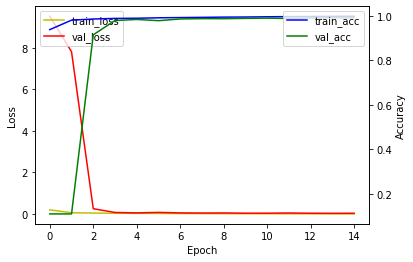

In [21]:
acc_loss_plot(history)